# SYSID - Atividade 08

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

Nosso objetivo será estudar a implementação de redes neurais para fins de identificação de sistemas. Será usado o pacote TensorFlow com o conjunto de dados motivador sendo o do braço robótico até agora estudado.

## Referêcias

Esse Nb não foi criado do zero. Para conhecer melhor o original, visite:

https://github.com/helonayala/narx_narendra

## Passo 0 - Importando bibliotecas

In [169]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from scipy import signal

from sysid_utils import *

# set random seed (reproducibility)
rseed = 42
np.random.seed(rseed)
tf.random.set_seed(rseed)
# print precision
np.set_printoptions(precision=3)


## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [170]:
data = np.genfromtxt('../data/robot_arm.dat')
X1 = data[:,0]
y = data[:,1]

### 0.2 - Visualizando dados

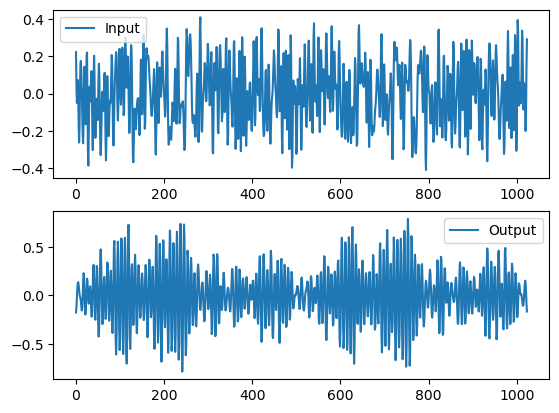

In [171]:
fig, ax = plt.subplots(2,1)
ax[0].plot(X1, label='Input')
ax[1].plot(y, label='Output')
ax[0].legend()
ax[1].legend()

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [172]:
p_train = 0.90 # 95% treino

### 1.2 - Separando os conjuntos

In [173]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train]
y_tr = y[:n_train]
X1_te = X1[n_train:]
y_te = y[n_train:]

In [174]:
print(
    X1_tr.shape,
    X1_te.shape
)

(921,) (103,)


## Passo 2 - Criando o modelo

### 2.1 - Criando matriz de regressão

In [175]:
ny = 4
nu = 6 # model orders
(Ye,Phie) = matReg(y_tr,X1_tr,ny,nu)
(Yt,Phit) = matReg(y_te,X1_te,ny,nu)

### 2.2 - Definindo arquitetura do modelo

In [176]:
_ , ninp = Phie.shape
nout = 1
nneu = 100 # how many neurons per layer
nlyers = 6
act_func = 'relu'

# model definition
input_ = keras.layers.Input(shape=(ninp,))
hlayer = input_
for i in range(nlyers):
    hlayer = keras.layers.Dense(nneu, activation=act_func,kernel_initializer="lecun_normal",)(hlayer)
output = keras.layers.Dense(nout)(hlayer)

# instantiate model
model = keras.models.Model(inputs=[input_],outputs=[output])

# define optimizer and learning rate
optimizer = keras.optimizers.Nadam(lr = 1e-3)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)


/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 2.3 - Treinando o modelo

In [177]:
history = model.fit(Phie, Ye, epochs=100)#, batch_size = 256)

Epoch 1/100
29/29 [==============================] - 1s 5ms/step - loss: 0.0180
Epoch 2/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 4/100
29/29 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 5/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 6/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 7/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 8/100
29/29 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 9/100
29/29 [==============================] - 0s 10ms/step - loss: 7.8402e-04
Epoch 10/100
29/29 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 11/100
29/29 [==============================] - 0s 9ms/step - loss: 7.1448e-04
Epoch 12/100
29/29 [==============================] - 0s 9ms/step - loss: 8.9671e-04
Epoch 13/100
29/29 [

## Passo 3 - Comparando os resultados com os dados

### 3.1 - Simulação OSA

In [178]:
# One step ahead
y_train_pred1 = model.predict(Phie)
y_test_pred1  = model.predict(Phit)

R2test1  = r2_score(Yt, y_test_pred1)
R2train1 = r2_score(Ye, y_train_pred1)


4/4 [==============================] - 0s 2ms/step


In [179]:
print('-------------- One step ahead  --------------')
print('R2test1  =')
print(R2test1)
print('R2train1  =')
print(R2train1)

-------------- One step ahead  --------------
R2test1  =
0.9923729605724075
R2train1  =
0.9991879109805558


### 3.2 - Simulação FS

In [180]:
# Free Run
# y_train_pred0 = freeRun(model,ye,ue,ny,nu)
y_test_pred0  = freeRun(model,y_te,X1_te,ny,nu)

# R2train0 = r2_score(Ye, y_train_pred0)
R2test0  = r2_score(Yt, y_test_pred0)


1/1 [==============================] - 0s 42ms/step


In [181]:
print('-------------- Free Run  --------------')
print('R2test0  =')
print(R2test0)


-------------- Free Run  --------------
R2test0  =
0.9137859924147057


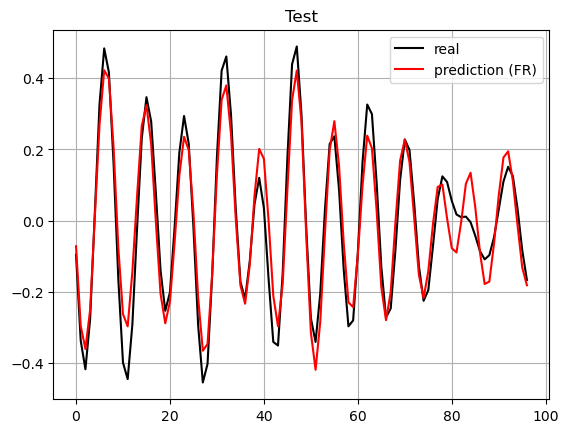

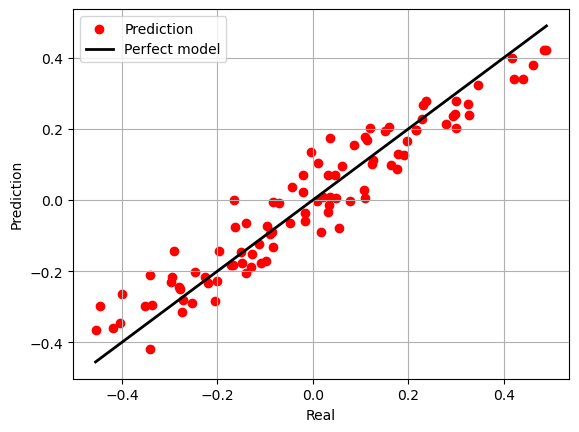

In [182]:
plt.figure()
plt.plot(Yt,'k',y_test_pred0,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt),min(y_test_pred0))
maxY = max(max(Yt),max(y_test_pred0))
plt.scatter(Yt,y_test_pred0,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()

## Passo 4 - Conclusões

* Foi possível atingi um valor de $R^2$ muito bom usando um modelo de mesma ordem que o estudado no ARMAX/NARMAX e redes neurais
    * O modelo teve que ter um conjunto de treino maior, levando a uma FS de menor período
    * O modelo teve que ser razoavelmente complexo, com 6 camadas
